In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import sys
sys.path.insert(0, '..')
from isegm.ritm.utils import exp

device = torch.device('cuda:0')
# cfg = exp.load_config_file('config.yml', return_edict=True)

In [68]:
from hydra import compose, initialize
from omegaconf import OmegaConf

overrides = [
    "datasets=['MD_PANC_2D_VAL']",
    "model_training_paths=['/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training/final_models/UnetPlusPlus-MD_PANC_2D-Static disks']",
    "exp_name='MD_PANC_SMALL'",
    "hydra.job.chdir=False",
]

with initialize(version_base=None, config_path="./configs", job_name="eval_test"):
    cfg = compose(config_name="evaluation_config", overrides=overrides)

print(OmegaConf.to_yaml(cfg))

data_paths:
  INTERACTIVE_MODELS_PATH: ./weights
  EXPS_PATH: ./experiments
  GRABCUT_PATH: /home/admin/workspace/project/data/datasets/GrabCut
  BERKELEY_PATH: /home/admin/workspace/project/data/datasets/Berkeley
  DAVIS_PATH: /home/admin/workspace/project/data/datasets/DAVIS
  COCO_MVAL_PATH: /home/admin/workspace/project/data/datasets/COCO_MVal
  PASCALVOC_PATH: /home/admin/workspace/project/data/datasets/VOC2012/VOCdevkit/VOC2012
  DAVIS585_PATH: /home/admin/workspace/project/data/datasets/InterDavis/Selected_480P
  BRATS_VAL_PATH: /gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/BraTS_2d/val
  LIDC_VAL_PATH: /gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D/val
  LIDC_TEST_PATH: /gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D/test
  LIDC_FULL_VAL_PATH: /gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D-FULL/val
  LIDC_FULL_TEST_P

In [158]:
from __future__ import annotations
import logging

import sys
import os
from pathlib import Path
import yaml

import torch
import hydra
import pandas as pd
from omegaconf import DictConfig, OmegaConf

sys.path.insert(0, '.')
from isegm.inference import utils
from isegm.inference.iterative_evaluation_training import evaluate_dataset
from isegm.data.preprocess import Preprocessor

In [159]:
cfg.data_paths.EXPS_PATH = Path(cfg.data_paths.EXPS_PATH)

if cfg.logs_path == '':
    cfg.logs_path = cfg.data_paths.EXPS_PATH / 'evaluation_logs'
else:
    cfg.logs_path = Path(cfg.logs_path)

In [160]:
import logging
logFormatter = logging.Formatter("%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s")
rootLogger = logging.getLogger()
consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logFormatter)
rootLogger.addHandler(consoleHandler)
logger = rootLogger

logger.setLevel(logging.INFO)
logger.info(f'Logs will be saved to {cfg.logs_path}')

2024-05-03 19:27:51,707 [MainThread  ] [INFO ]  Logs will be saved to evaluation_logs
2024-05-03 19:27:51,707 [MainThread  ] [INFO ]  Logs will be saved to evaluation_logs
2024-05-03 19:27:51,707 [MainThread  ] [INFO ]  Logs will be saved to evaluation_logs
2024-05-03 19:27:51,707 [MainThread  ] [INFO ]  Logs will be saved to evaluation_logs


In [161]:
device = torch.device('cpu' if cfg.cpu else f"cuda:{cfg.gpus.split(',')[0]}")
device

device(type='cuda', index=0)

In [162]:
output_dir = './test_output'

In [74]:
def get_run_config(checkpoints_list, path):
    # checkpoints_list.append(path / 'checkpoints' / 'iterative_best_model.pth')
    checkpoints_list.append(path / 'checkpoints' / 'best_model.pth')
    # checkpoints_list.append(path / 'checkpoints' / 'last_checkpoint.pth')

    hydra_config_dir = path / '.hydra'

    base_config = OmegaConf.load(str(hydra_config_dir / "config.yaml"))
    base_config = OmegaConf.to_container(base_config, resolve=True)

    overrides = OmegaConf.load(str(hydra_config_dir / "overrides.yaml"))
    overrides = [
        (override.split('=')[0], override.split('=')[1]) for override in overrides
    ]

    for key, value in overrides:
        keys = key.split('.')
        current_dict = base_config

        for k in keys[:-1]:
            if k in current_dict:
                current_dict = current_dict[k]
            else:
                current_dict[k] = {}
                current_dict = current_dict[k]

        current_dict[keys[-1]] = yaml.safe_load(value)

    return base_config


In [163]:
def load_model_setups(cfg):
    if 'model_training_paths' in cfg and cfg.model_training_paths != None:
        training_paths = [Path(x) for x in cfg.model_training_paths]
        checkpoints_list = []
        preprocessor_list = []
        model_names = []
        train_configs = []
        for path in training_paths:
            run_config = get_run_config(checkpoints_list, path)
            preprocessor_list.append(Preprocessor(run_config['preprocessing']))
            model_name = run_config['exp_name']
            if 'multirun' in str(path):
                model_name += f'__{path.stem}'
            model_names.append(model_name)
            train_configs.append(run_config)
    elif 'model_training_parent_dir' in cfg and cfg.model_training_parent_dir != None:
        training_paths = [Path(os.path.join(cfg.model_training_parent_dir, x)) for x in cfg.model_training_parent_dir]
        checkpoints_list = []
        preprocessor_list = []
        model_names = []
        train_configs = []
        for path in training_paths:
            run_config = get_run_config(checkpoints_list, path)
            preprocessor_list.append(Preprocessor(run_config['preprocessing']))
            model_name = run_config['exp_name']
            if 'multirun' in str(path):
                model_name += f'__{path.stem}'
            model_name = f'{run_config["model_type"]}_{model_name}'
            model_names.append(model_name)
            train_configs.append(run_config)
    else:
        checkpoints_list = [
            os.path.join(cfg.models_path, x) for x in os.listdir(cfg.models_path)
        ]
        checkpoints_list = [Path(x) for x in checkpoints_list]
        model_names = [x.stem for x in checkpoints_list]
        preprocessor_list = [Preprocessor() for _ in checkpoints_list]
        train_configs = [None for _ in checkpoints_list]

    model_setups = [
        {
            'model_name': model_name,
            'checkpoint_path': checkpoint_path,
            'preprocessor': preprocessor,
            'train_config': train_config,
            'type': train_config['model_type']
        }
        for model_name, checkpoint_path, preprocessor, train_config in zip(
            model_names, checkpoints_list, preprocessor_list, train_configs
        )
    ]

    return model_setups

In [164]:
summary_rows = []
logger.info(f'Start progressive merge after: {cfg.start_progressive_merge} clicks')
model_setups = load_model_setups(cfg)

2024-05-03 19:28:00,894 [MainThread  ] [INFO ]  Start progressive merge after: -1 clicks
2024-05-03 19:28:00,894 [MainThread  ] [INFO ]  Start progressive merge after: -1 clicks
2024-05-03 19:28:00,894 [MainThread  ] [INFO ]  Start progressive merge after: -1 clicks
2024-05-03 19:28:00,894 [MainThread  ] [INFO ]  Start progressive merge after: -1 clicks


In [165]:
dataset_name = cfg.datasets[0]
print(dataset_name)
dataset = utils.get_dataset(dataset_name, cfg.data_paths)
len(dataset)

MD_PANC_2D_VAL


29

In [166]:
# list parameters of preprocessor with their values
preprocessor =dataset.preprocessor
preprocessor_dict = preprocessor.__dict__
for key in preprocessor_dict:
    print(key, preprocessor_dict[key])

enhancements []
normalize True
windowing False
convert_to_rgb False
num_input_channels 3


In [167]:
# dataset.dataset_samples = dataset.dataset_samples[11:12]
# print(len(dataset.dataset_samples))
# plt.imshow(dataset.get_sample(0).image[:,:, 0], cmap='gray')

In [143]:
def get_model_summary(model_name, dataset_name, mean_ious, noc, nof, iou_error):
    summary_row = [model_name, dataset_name]
    summary_row.extend(mean_ious)
    summary_row.extend(noc)
    summary_row.extend(nof)
    summary_row.extend([iou_error])
    return summary_row

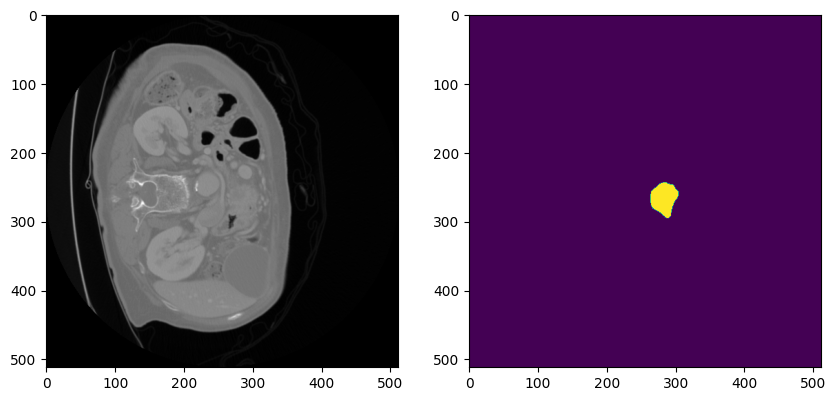

In [168]:
sample = dataset.get_sample(0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample.image[:, :, 0], cmap='gray')
ax[1].imshow(sample.gt_mask)

In [169]:
models_to_evaluate = model_setups[:2]
print([model['model_name'] for model in models_to_evaluate])

['Static disks']


Model args: {'with_prev_mask': False, 'dist_map_mode': 'disk', 'dist_map_radius': 5, 'model_type': 'UnetPlusPlus'}


2024-05-03 19:28:18,388 [MainThread  ] [INFO ]  Evaluating model /gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training/final_models/UnetPlusPlus-MD_PANC_2D-Static disks/checkpoints/best_model.pth
2024-05-03 19:28:18,388 [MainThread  ] [INFO ]  Evaluating model /gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training/final_models/UnetPlusPlus-MD_PANC_2D-Static disks/checkpoints/best_model.pth
2024-05-03 19:28:18,388 [MainThread  ] [INFO ]  Evaluating model /gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training/final_models/UnetPlusPlus-MD_PANC_2D-Static disks/checkpoints/best_model.pth
2024-05-03 19:28:18,388 [MainThread  ] [INFO ]  Evaluating model /gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training/final_models/UnetPlusPlus-MD_PANC_2D-Static disks/checkpoints/best_model.pth
2024-05-03 19:28:18,395 [MainThread  ] [INFO ]  Loaded <class 'isegm.model.is_unetpluspl

['Static disks', 'MD_PANC_2D_VAL', 0.5100308840282607, 0.5891518760938359, 0.6066822449552487, 0.6170254881179144, 0.6308047247993378, 0.6443822989698909, 0.6530021591941279, 0.6727364880396481, 0.6763521221831288, 0.681339821063061, 0.6889647604750321, 0.6879929099041846, 0.6946398907471348, 0.693730456542128, 0.6929818475451299, 0.7001100073425746, 0.7052023362501436, 0.7086538666776421, 0.7156733889558585, 0.7196976263542598, 16.310344827586206, 19.448275862068964, 20.0, 19, 27, 29, 0.3221482354507593]


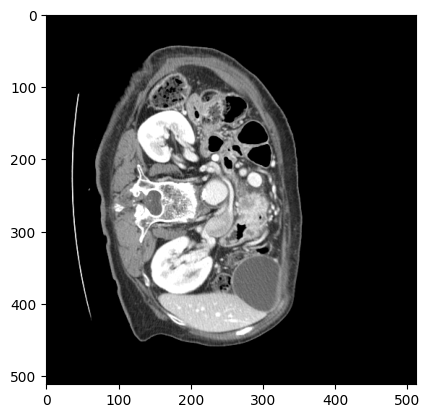

In [170]:
from copy import copy

model_mean_ious = {}

for model_setup in models_to_evaluate:
    # print(model_setup['model_name'], model_setup['checkpoint_path'])
    model = utils.load_is_model(
        model_setup['checkpoint_path'],
        device,
        model_type=model_setup['type'],
    )
    # model.dist_maps_base.mode = 'gaussian'
    # print(model.dist_maps.__class__)
    # for param in dir(model.dist_maps):
    #     if not param.startswith('_') and not callable(model.dist_maps.__getattribute__(param)):
    #         logger.info(f'{param}: {model.dist_maps.__getattribute__(param)}')
            
    logger.info(f'Evaluating model {model_setup["checkpoint_path"]}')
    logger.info(f'Loaded {model.__class__} model for type {model_setup["type"]}')

    if 'clicker' in model_setup['train_config'].keys():
        clicker_config = copy(model_setup['train_config']['clicker'])
        logger.info(f'Model clicker config loaded: {clicker_config}')

        # Backwards compatibility :(
        if 'dynamic_radius_points' in model_setup['train_config'] and not model_setup['train_config']['dynamic_radius_points']:
            clicker_config['mode'] = 'locked'

        if clicker_config['mode'] == 'distributed':
            clicker_config['mode'] = 'avg' # Deterministic
        if clicker_config['mode'] == 'distributed_only_pos':
            clicker_config['mode'] = 'avg_only_pos' # Deterministic
        clicker_config['size_range_modifier'] = 0 # Deterministic
        logger.info(f'Model clicker config used: {clicker_config}')

        # logger.info(f'Model {"is" if model.dist_maps.overwrite_maps else "is not"} overwriting click maps!')

    else:
        clicker_config = {
            'mode':'locked',
            'size_range_modifier': 0
        }
        logger.info(f'Clicker config not found for model {model_setup["model_name"]}. Defaulting to locked')

    if cfg.force_clicker_config:
        clicker_config = cfg.clicker_config
        logger.info(f'Forcing clicker config: {clicker_config}')
        
    zoom_in_params = dict()
    # if cfg.use_init_mask:
    #     zoom_in_params['skip_clicks'] = 0
    # if cfg.zoom_in.enabled:
    #     zoom_in_params['optimistic_masking'] = cfg.zoom_in.optimistic_masking
    zoom_in_params['recompute_click_size_on_zoom'] = clicker_config['mode'] != 'locked'
    logger.info(f'Zoom in params: {zoom_in_params}')
    
    predictor_params = dict()
    if model_setup['type'] == 'FocalClick':
        predictor_params['ensure_minimum_focus_crop_size'] = cfg.predictor.ensure_minimum_focus_crop_size
        
    logger.info(f'Predictor params: {predictor_params}')

    predictor = utils.get_predictor(
            model_setup['type'],
            model,
            device,
            zoom_in_params,
            predictor_params
        )

    logger.info(f'Loaded {predictor.__class__} predictor for type {model_setup["type"]}')
    
    dataset.preprocessor = model_setup['preprocessor']
    logger.info(
        f'Evaluating {dataset.epoch_len} samples from {dataset_name}...'
    )
    for param in dir(dataset.preprocessor):
        if not param.startswith('_') and not callable(dataset.preprocessor.__getattribute__(param)):
            logger.info(f'{param}: {dataset.preprocessor.__getattribute__(param)}')
    
    plt.imshow(dataset.get_sample(0).image[:,:, 0], cmap='gray')      
    
    mean_ious, noc, nof, iou_error, all_ious = evaluate_dataset(
        dataset,
        predictor,
        logger=logger,
        clicker_config=clicker_config,
        pred_thr=0.49 if model_setup['type'] == 'UnetPlusPlus' else cfg.thresh,
        max_iou_thr=cfg.target_iou,
        min_clicks=cfg.min_n_clicks,
        max_clicks=cfg.n_clicks,
        use_init_mask=cfg.use_init_mask,
        start_progressive_merge_on_click=cfg.start_progressive_merge,
    )
    summary_row = get_model_summary(
        model_setup['model_name'], dataset_name, mean_ious, noc, nof, iou_error
    )
    print(summary_row)
    model_mean_ious[model_setup['model_name']] = mean_ious
    

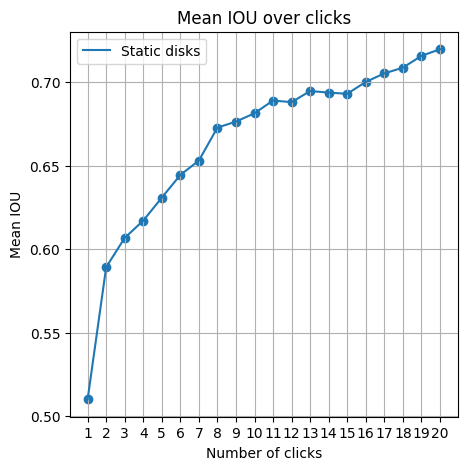

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for model_name, mean_ious in model_mean_ious.items():
    ax.plot(np.arange(1,len(mean_ious) + 1), mean_ious, label=model_name)
    ax.scatter(np.arange(1,len(mean_ious) + 1), mean_ious)
ax.set_title(f'Mean IOU over clicks')
ax.set_xlabel('Number of clicks')
ax.set_ylabel('Mean IOU')
ax.set_xticks(np.arange(1, len(mean_ious) + 1))
# ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.grid()
ax.legend()